In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

/tmp/ipython-input-2558551367.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(url, header=0, parse_dates=[0], index_col=0)
/tmp/ipython-input-2558551367.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(url, header=0, parse_dates=[0], index_col=0)


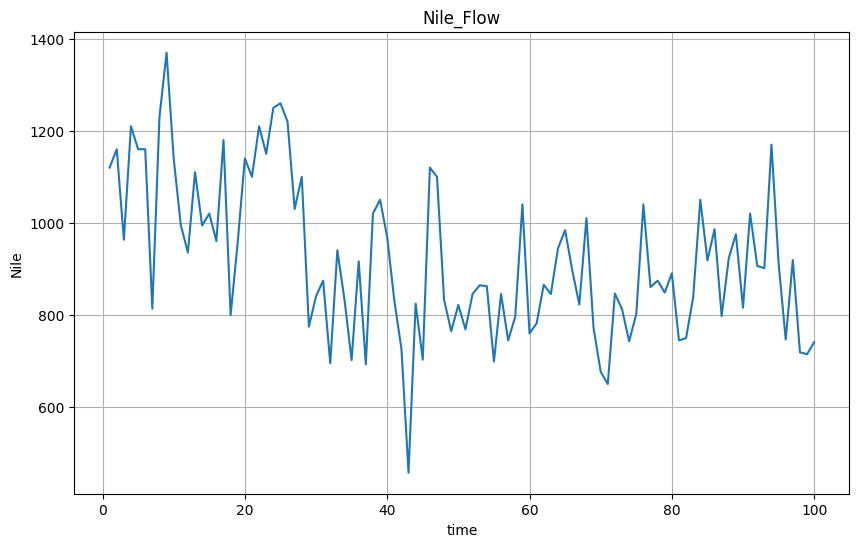

In [4]:
# Load the dataset
url = "https://raw.githubusercontent.com/baren-kumar/ML-/refs/heads/main/Nile.csv"
data = pd.read_csv(url, header=0, parse_dates=[0], index_col=0)
data = data["Nile"]
# Plot the data
plt.figure(figsize=(10, 6))
data.plot()
plt.title("Nile_Flow")
plt.xlabel("time")
plt.ylabel("Nile")
plt.grid(True)
plt.show()

In [5]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

# Function to create dataset with lag features
def create_lagged_data(data, lag=1):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i + lag])
        y.append(data[i + lag])
    return np.array(X), np.array(y)

# Use a lag of 12 for monthly data (1 year worth of data)
lag = 12
X, y = create_lagged_data(data_scaled, lag)

# Reshape input to [samples, time steps, features] for LSTM/GRU
X = X.reshape(X.shape[0], X.shape[1], 1)

In [110]:
# Train-test split (use the last 12 months as test set)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [111]:
# Split into train and test sets
split_ratio = 0.9
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [112]:
# Flatten input for Random Forest (doesn't need 3D input like LSTM)
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)


In [113]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [114]:
# Predict
y_pred_rf = rf_model.predict(X_test_rf)

In [115]:
# Evaluate using RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {rf_rmse:.4f}")

Random Forest RMSE: 0.1828


In [116]:
# Flatten input for SVR (like with Random Forest)
X_train_svm = X_train.reshape(X_train.shape[0], -1)
X_test_svm = X_test.reshape(X_test.shape[0], -1)


In [117]:
# Initialize and fit the SVM model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_svm, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [118]:
# Predict
y_pred_svm = svm_model.predict(X_test_svm)

In [119]:
# Evaluate using RMSE
svm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svm))
print(f"SVM RMSE: {svm_rmse:.4f}")

SVM RMSE: 0.1443


In [120]:
# Reshape for ANN: (samples, features)
X_train_ann = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_ann = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [121]:
# Build ANN model
ann_model = Sequential()
ann_model.add(Dense(64, input_dim=X_train_ann.shape[1], activation='relu'))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1))  # Output layer for regression


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [122]:
# Compile the model
ann_model.compile(optimizer='adam', loss='mse')


In [123]:
# Train the model
ann_model.fit(X_train_ann, y_train, epochs=100, batch_size=16, verbose=0)


In [124]:
# Predict
y_pred_ann = ann_model.predict(X_test_ann)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


In [128]:
# Evaluate using RMSE
ann_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ann))
print(f"ANN RMSE: {ann_rmse:.4f}")

ANN RMSE: 0.1880


In [127]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))

In [129]:
# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')


In [130]:
# Fit the model
lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

In [131]:
# Predict
y_pred_lstm = lstm_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


In [86]:
# Evaluate
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
print(f"LSTM RMSE: {lstm_rmse:.4f}")

LSTM RMSE: 0.1590


In [132]:
# Build GRU model
gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
gru_model.add(GRU(50, return_sequences=False))
gru_model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [133]:
# Compile the model
gru_model.compile(optimizer='adam', loss='mse')


In [134]:
# Fit the model
gru_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

In [135]:
# Predict
y_pred_gru = gru_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


In [136]:
# Evaluate
gru_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gru))
print(f"GRU RMSE: {gru_rmse:.4f}")

GRU RMSE: 0.1474


In [137]:
 # Store RMSE results in a dictionary for comparison
rmse_results = {
    'Random Forest': rf_rmse,
    'SVM': svm_rmse,
    'ANN': ann_rmse,
    'LSTM': lstm_rmse,
    'GRU': gru_rmse
}

# Display RMSE results
print("RMSE Comparison for Models:")
for model, rmse in rmse_results.items():
    print(f"{model}: {rmse:.4f}")

RMSE Comparison for Models:
Random Forest: 0.1828
SVM: 0.1443
ANN: 0.1880
LSTM: 0.1590
GRU: 0.1474


/tmp/ipython-input-110037876.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(rmse_results.keys()), y=list(rmse_results.values()), palette="viridis")


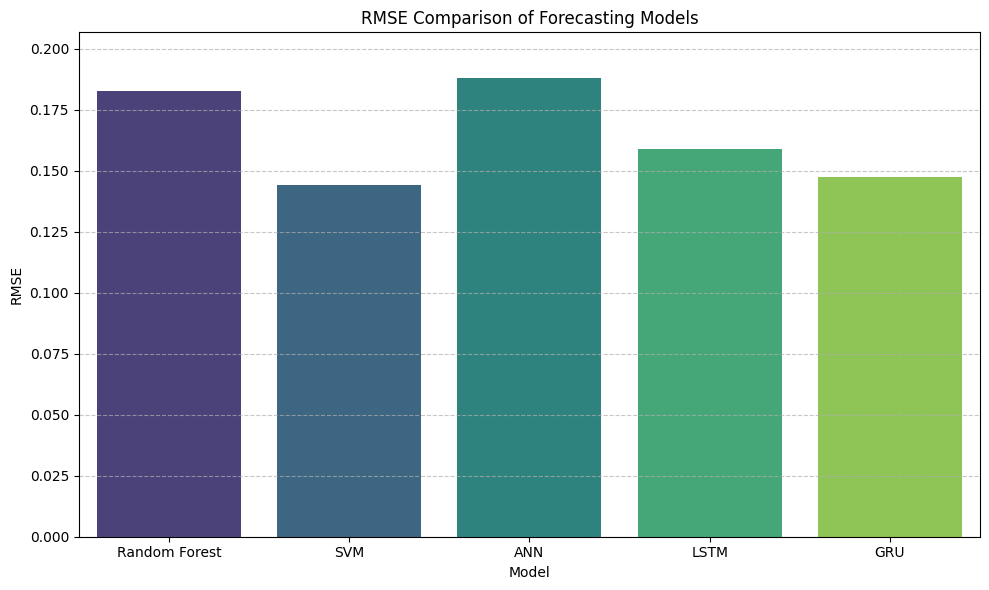

In [138]:
# Plotting the RMSE comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=list(rmse_results.keys()), y=list(rmse_results.values()), palette="viridis")
plt.title('RMSE Comparison of Forecasting Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_results.values()) * 1.1)  # Add headroom for clarity
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

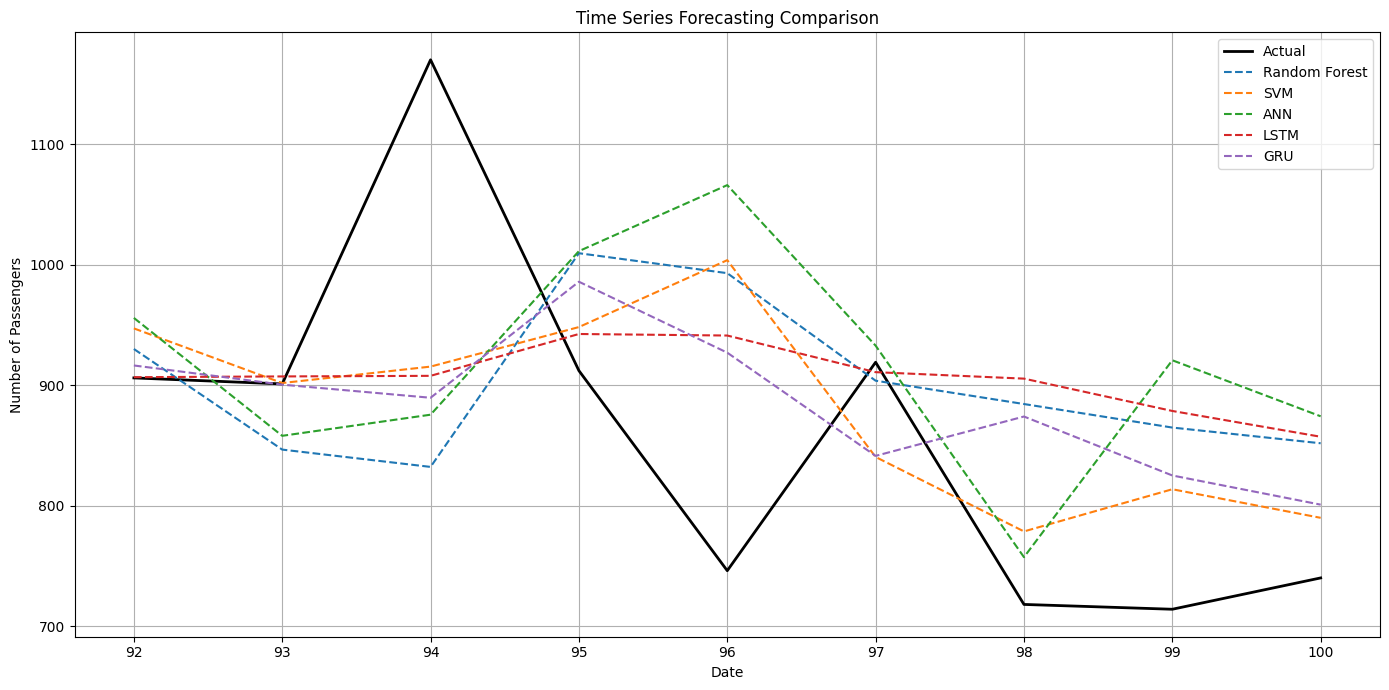

In [139]:
# Inverse transform predictions and true values back to original scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_rf_inv = scaler.inverse_transform(y_pred_rf.reshape(-1, 1)).flatten()
y_pred_svm_inv = scaler.inverse_transform(y_pred_svm.reshape(-1, 1)).flatten()
y_pred_ann_inv = scaler.inverse_transform(y_pred_ann.reshape(-1, 1)).flatten()
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_pred_gru_inv = scaler.inverse_transform(y_pred_gru.reshape(-1, 1)).flatten()

# Get the corresponding dates for the test set
test_index = data.index[lag + len(y_train):]  # Align time index with test data

# Plot time series: actual vs predicted
plt.figure(figsize=(14, 7))
plt.plot(test_index, y_test_inv, label='Actual', color='black', linewidth=2)
plt.plot(test_index, y_pred_rf_inv, label='Random Forest', linestyle='--')
plt.plot(test_index, y_pred_svm_inv, label='SVM', linestyle='--')
plt.plot(test_index, y_pred_ann_inv, label='ANN', linestyle='--')
plt.plot(test_index, y_pred_lstm_inv, label='LSTM', linestyle='--')
plt.plot(test_index, y_pred_gru_inv, label='GRU', linestyle='--')

plt.title('Time Series Forecasting Comparison')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [140]:
# 1. Find best model name and RMSE
best_model_name = min(rmse_results, key=rmse_results.get)
best_rmse = rmse_results[best_model_name]
print(f"Best model: {best_model_name} with RMSE = {best_rmse:.4f}")

# 2. Map model name to model object
model_map = {
    'Random Forest': rf_model,
    'SVM': svm_model,
    'ANN': ann_model,
    'LSTM': lstm_model,
    'GRU': gru_model
}

best_model = model_map[best_model_name]


Best model: SVM with RMSE = 0.1443


In [141]:
# Parameters
forecast_steps = 50  # 50 month
lag = X_train.shape[1]  # lag size, should be 12


In [142]:
# 3. Prepare initial input sequence for forecasting: last `lag` data points scaled
last_sequence = data_scaled[-lag:].reshape(1, lag, 1)  # shape (1, lag, 1)

forecast_scaled = []


In [143]:
# 4. Forecast loop depends on model type (reshape inputs accordingly)
for _ in range(forecast_steps):
    if best_model_name in ['LSTM', 'GRU']:
        # For LSTM/GRU, input shape is (1, lag, 1)
        next_pred = best_model.predict(last_sequence)[0, 0]
        forecast_scaled.append(next_pred)
        # Update input sequence by appending prediction and removing oldest value
        last_sequence = np.append(last_sequence[:, 1:, :], [[[next_pred]]], axis=1)

    elif best_model_name == 'ANN':
        # ANN expects 2D input shape (samples, features)
        input_ann = last_sequence.reshape(1, lag)
        next_pred = best_model.predict(input_ann)[0, 0]
        forecast_scaled.append(next_pred)
        # Update last_sequence accordingly
        new_seq = np.append(last_sequence.flatten()[1:], next_pred)
        last_sequence = new_seq.reshape(1, lag, 1)

    else:
        # For Random Forest and SVM: 2D input (samples, features)
        input_rf_svm = last_sequence.reshape(1, lag)
        next_pred = best_model.predict(input_rf_svm)[0]
        forecast_scaled.append(next_pred)
        new_seq = np.append(last_sequence.flatten()[1:], next_pred)
        last_sequence = new_seq.reshape(1, lag, 1)

In [144]:
# 5. Inverse transform forecasted values
forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()


In [155]:
# 6. Create future dates starting after last date in data

data.index = pd.to_datetime(data.index)
last_date = data.index[-1]

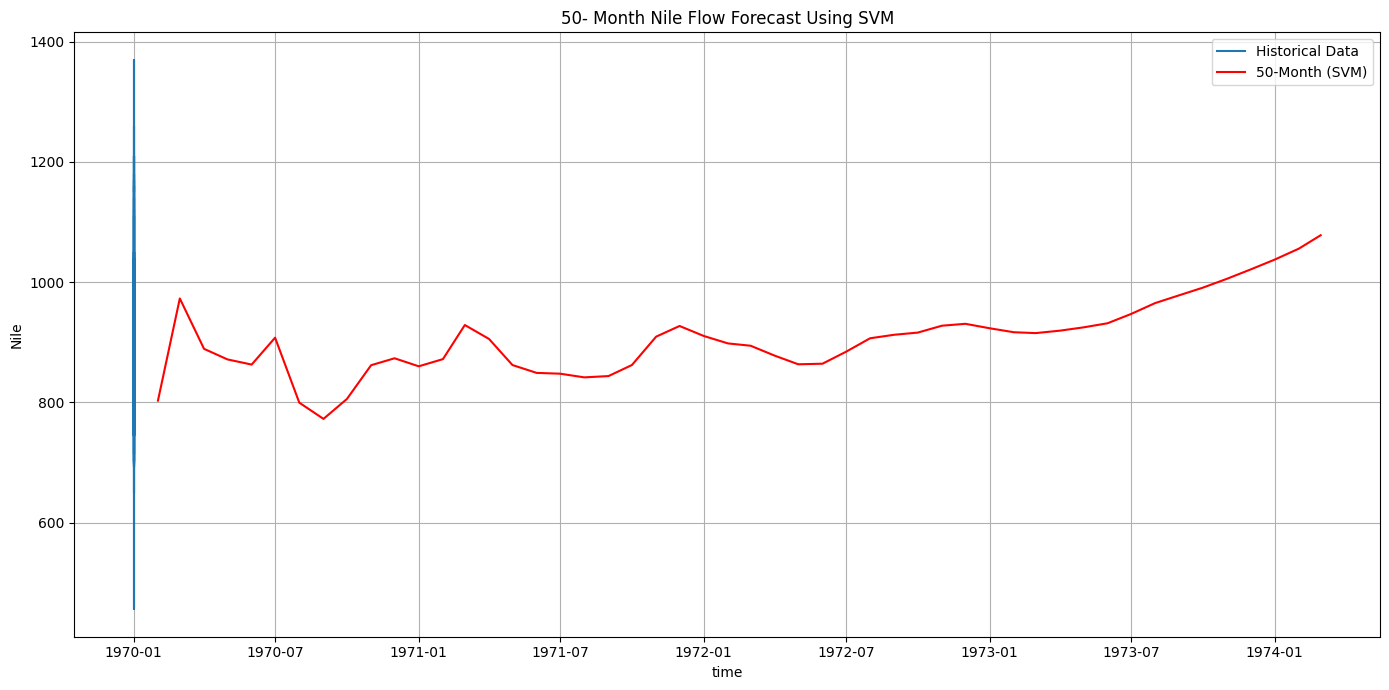

In [156]:
# 7. Plot historical data + forecast
plt.figure(figsize=(14, 7))
plt.plot(data.index, data.values, label='Historical Data')
plt.plot(future_dates, forecast, label=f'50-Month ({best_model_name})', color='red')
plt.title(f'50- Month Nile Flow Forecast Using {best_model_name}')
plt.xlabel('time')
plt.ylabel('Nile')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()